In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score

DATA_DIR = '/Users/ccnlab/Development/dynamic_noise_estimation/dynamic_foraging/code'

In [32]:
num_agent = 1000
num_trials = 720
method = 'mle'
prefix = f'rw_{num_agent}a_{num_trials}t_dynamic_foraging'
mle_recover_param = pd.read_csv(f'{DATA_DIR}/{method}_parameters_{prefix}.csv')
true_param = pd.read_csv(f'{DATA_DIR}/{prefix}_parameters.csv')

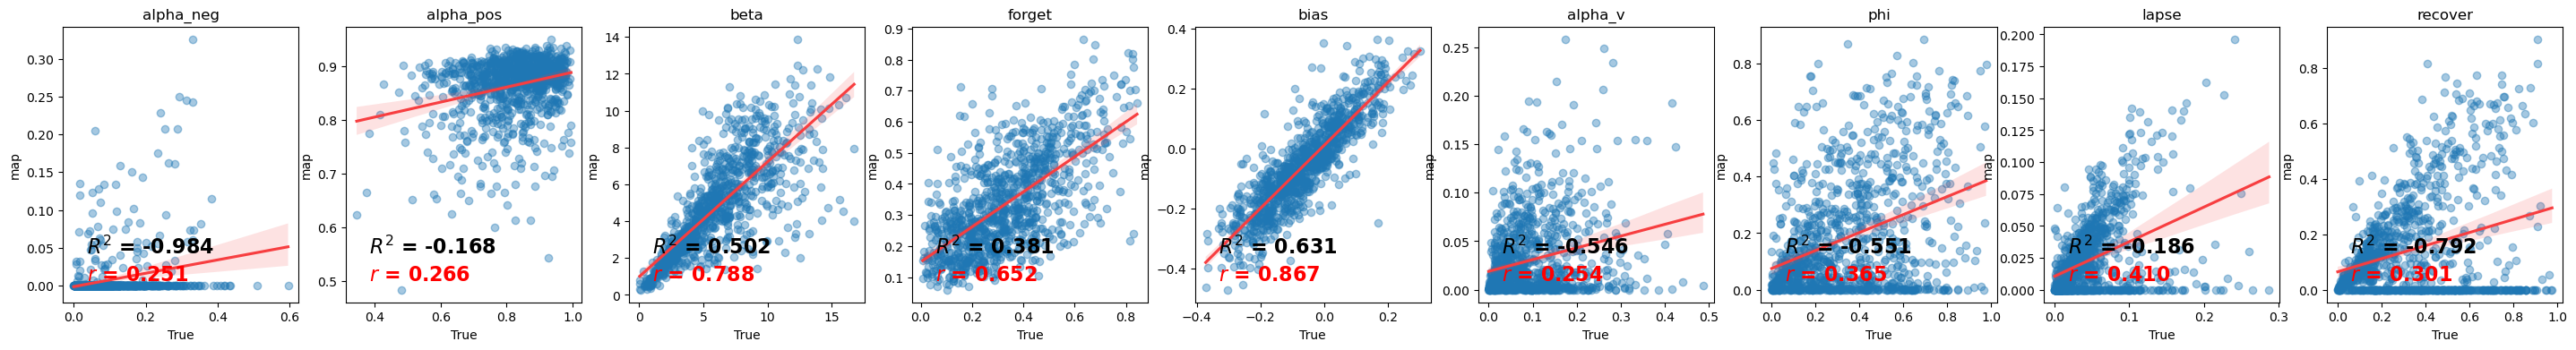

In [33]:
param_names = true_param.keys()
no_col = len(param_names)
f, axarr = plt.subplots(1, no_col, figsize=(4 * no_col, 4 * 1), sharey=False)
for idx, p in enumerate(param_names):
    result = pd.DataFrame({"True": true_param[p], method: mle_recover_param[p]})
    ax = sns.regplot(
        data=result,
        ci=99,
        x="True",
        y=method,
        ax=axarr.flat[idx],
        line_kws=dict(color="#f73e40"),
        scatter_kws=dict(alpha=0.4),
    )

    r2 = r2_score(true_param[p], mle_recover_param[p])
    ax.text(
        0.1,
        0.2,
        "$R^2$ = {:.3f}".format(r2),
        horizontalalignment="left",
        verticalalignment="center",
        color="black",
        fontweight="heavy",
        transform=ax.transAxes,
        size=16,
    )

    corr = np.corrcoef(true_param[p], mle_recover_param[p])[0, 1]
    ax.text(
        0.1,
        0.1,
        "$r$ = {:.3f}".format(corr),
        horizontalalignment="left",
        verticalalignment="center",
        color="red",
        fontweight="heavy",
        transform=ax.transAxes,
        size=16,
    )
    #ax.set_ylim(0, 1)
    ax.set_title(p, fontsize=12)

In [42]:
method = 'benchmark'
mle_latent_recover_param = pd.read_csv(f'{DATA_DIR}/{method}_latent_{prefix}.csv')
sim_data = pd.read_csv(f'{DATA_DIR}/{prefix}.csv')
mle_latent_recover_param.shape

(1000, 720)

In [43]:
num_agent = len(sim_data['agentid'].unique())
num_trials = len(sim_data['trials'].unique())
true_latent = sim_data['latent_att'].to_numpy().reshape(num_agent, num_trials)
true_latent_prob = sim_data['latent_prob'].to_numpy().reshape(num_agent, num_trials)

Text(0.5, 1.0, 'benchmark')

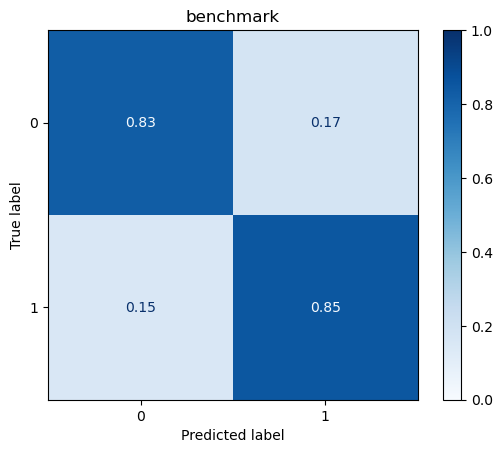

In [48]:
# @title chosen cue confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

pred_latent = (mle_latent_recover_param.to_numpy() >= 0.83).astype(int)
disp = ConfusionMatrixDisplay.from_predictions(
    true_latent.ravel(),
    pred_latent.ravel(),
    cmap=plt.cm.Blues,
    normalize='true')
# Set the fixed color bar range
disp.im_.set_clim(0, 1)
disp.ax_.set_title(method)

array([[<Axes: title={'center': 'agent 0'}, xlabel='trial #'>,
        <Axes: title={'center': 'agent 1'}, xlabel='trial #'>,
        <Axes: title={'center': 'agent 2'}, xlabel='trial #'>,
        <Axes: title={'center': 'agent 3'}, xlabel='trial #'>],
       [<Axes: title={'center': 'agent 4'}, xlabel='trial #'>,
        <Axes: title={'center': 'agent 5'}, xlabel='trial #'>,
        <Axes: title={'center': 'agent 6'}, xlabel='trial #'>,
        <Axes: title={'center': 'agent 7'}, xlabel='trial #'>]],
      dtype=object)

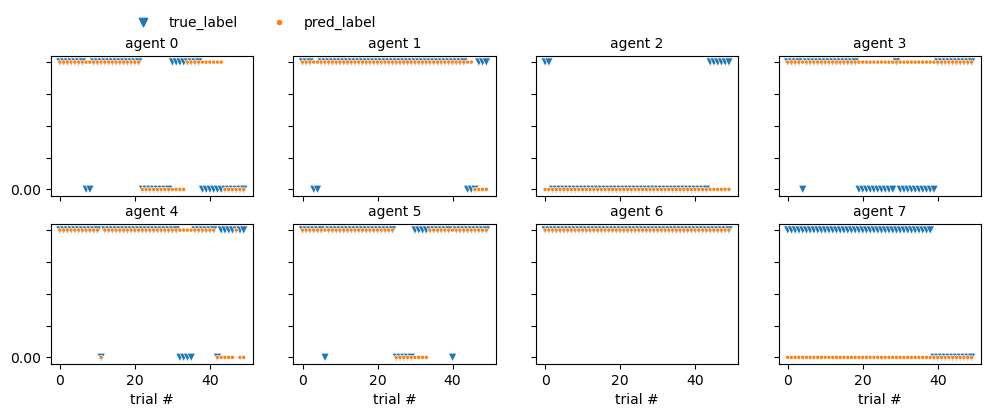

In [18]:
def plot_time_series(axes, y_true, y_pred, max_trial):
  for idx, ax in enumerate(axes.flat):
    result = pd.DataFrame({'true_label': y_true[idx][:max_trial], 'pred_label': y_pred[idx][:max_trial]})
    markers = {"true_label": "v", "pred_label": "."}
    show_legend = True if idx == 0 else False
    plot_ = sns.scatterplot(result, markers=markers, ax=ax, legend=show_legend) #lineplot
    if show_legend:
      sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(1, 1.1), ncol=2, title=None, frameon=False,
      )

    ax.set_xlabel('trial #')
    ax.set_title(f'agent {idx}', fontsize=10)
    for ind, label in enumerate(plot_.get_yticklabels()):
      if ind == 0 or ind == 1.0:  # every 10th label is kept
          label.set_visible(True)
      else:
          label.set_visible(False)  
  return axes

no_row, no_col = 2, 4
f, axarr = plt.subplots(no_row, no_col, figsize=(3 * no_col, 2 * no_row), sharey=True, sharex=True)
plot_time_series(axarr, true_latent, pred_latent, 50)

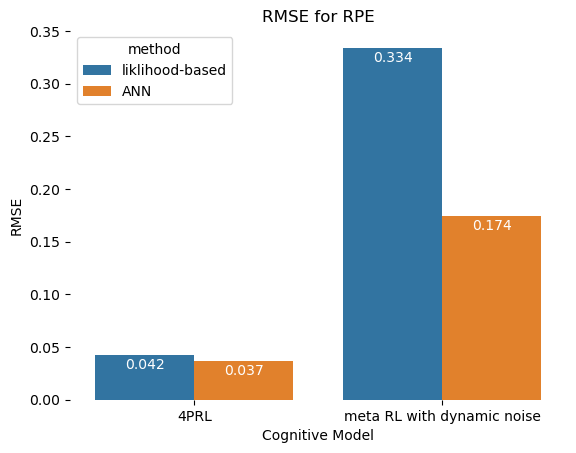

In [17]:
mse_result = pd.DataFrame(
    {
        "model": ["4PRL", "4PRL", "meta RL with dynamic noise", "meta RL with dynamic noise"],
        "rmse": [0.042, 0.037,  0.334, 0.174],
        "method": ["liklihood-based", "ANN", "liklihood-based", "ANN"],
        "tractable": ["yes", "yes", "no", "no"],
    }
)
r2_result = pd.DataFrame(
    {
        "model": ["GLM-HMM", "GLM-HMM", "meta RL with dynamic noise", "meta RL with dynamic noise"],
        "rmse": [0.8, 0.8, 0.43, 0.72],
        "method": ["liklihood-based", "ANN", "liklihood-based", "ANN"],
        "tractable": ["yes", "yes", "no", "no"],
    }
)
#f, axes = plt.subplot(1, 2, figsize=(3, 3))

b = sns.barplot(mse_result, x="model", y="rmse", hue="method", errorbar=None)
b.set_ylabel("RMSE")
b.set_xlabel("Cognitive Model")
b.set_title("RMSE for RPE")
b.get_legend().set_visible(True)
#b.set(ylim=(0, 0.5))

for i in b.containers:
    b.bar_label(i, fmt="%.3f", padding=-12, size=10, color="white")

sns.despine(bottom=True, left=True)